# Psychoinformatics - Week 14 (Examples)
by Tsung-Ren (Tren) Huang (trhuang@g.ntu.edu.tw)

In [7]:
%config IPCompleter.greedy=True 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import *
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 1 Recurrent Neural Network (RNN)

### 1.1 Example 1: Mapping Sin(t) to Cos(t)

In [56]:
#!pip install keras

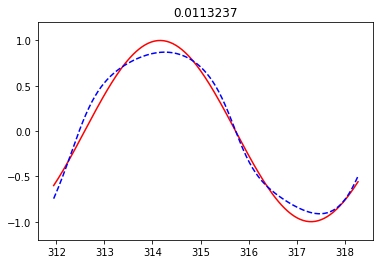

In [32]:
# 8 - RNN LSTM Regressor example
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense
from keras.optimizers import Adam

BATCH_START = 0
TIME_STEPS = 200
BATCH_SIZE = 50
INPUT_SIZE = 1
OUTPUT_SIZE = 1
CELL_SIZE = 20


def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START+TIME_STEPS*BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10*np.pi)
    seq = np.sin(xs)
    # seq = xs
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    # plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
    # plt.show()
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

model = Sequential()
# build a LSTM RNN
model.add(LSTM(
    batch_input_shape=(BATCH_SIZE, TIME_STEPS, INPUT_SIZE),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
    output_dim=CELL_SIZE,
    return_sequences=True,      # True: output at all steps. False: output as last step.
    stateful=True,              # True: the final state of batch1 is feed into the initial state of batch2
))
# add output layer
#model.add(TimeDistributed(Dense(OUTPUT_SIZE)))
model.add(Dense(OUTPUT_SIZE))
model.compile(optimizer='rmsprop',
              loss='mse',)

print('Training ------------')
for step in range(50):
    # data shape = (batch_num, steps, inputs/outputs)
    X_batch, Y_batch, xs = get_batch()
    cost = model.train_on_batch(X_batch, Y_batch)
    pred = model.predict(X_batch, BATCH_SIZE)
    plt.clf(); # clear previous figure
    plt.plot(xs[0, :], Y_batch[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--');
    plt.ylim((-1.2, 1.2));
    plt.title(str(cost));
    #plt.pause(0.5);
    display(plt.gcf()); clear_output(wait=True); # to allow dynamic plots

### 1.2 Example 2: Character-based RNN as a Language Model

In [5]:
from __future__ import print_function
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np


INPUT_FILE = "alice_in_wonderland.txt"

# extract the input as a stream of characters
print("Extracting text from input...")
fin = open(INPUT_FILE, 'rb')
lines = []
for line in fin:
    line = line.strip().lower()
    line = line.decode("ascii", "ignore")
    if len(line) == 0:
        continue
    lines.append(line)
fin.close()
text = " ".join(lines)

# creating lookup tables
# Here chars is the number of features in our character "vocabulary"
chars = set([c for c in text])
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

# create inputs and labels from the text. We do this by stepping
# through the text ${step} character at a time, and extracting a 
# sequence of size ${seqlen} and the next output char. For example,
# assuming an input text "The sky was falling", we would get the 
# following sequence of input_chars and label_chars (first 5 only)
#   The sky wa -> s
#   he sky was ->  
#   e sky was  -> f
#    sky was f -> a
#   sky was fa -> l
print("Creating input and label text...")
SEQLEN = 10
STEP = 1

input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i:i + SEQLEN])
    label_chars.append(text[i + SEQLEN])

# vectorize the input and label chars
# Each row of the input is represented by seqlen characters, each 
# represented as a 1-hot encoding of size len(char). There are 
# len(input_chars) such rows, so shape(X) is (len(input_chars),
# seqlen, nb_chars).
# Each row of output is a single character, also represented as a
# dense encoding of size len(char). Hence shape(y) is (len(input_chars),
# nb_chars).
print("Vectorizing input and label text...")
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1

# Build the model. We use a single RNN with a fully connected layer
# to compute the most likely predicted output char
HIDDEN_SIZE = 128
BATCH_SIZE = 128
NUM_ITERATIONS = 5
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100

model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=False,
                    input_shape=(SEQLEN, nb_chars),
                    unroll=True))
model.add(Dense(nb_chars))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

# We train the model in batches and test output generated at each step
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" % (iteration))
    model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)
    
    # testing model
    # randomly choose a row from input_chars, then use it to 
    # generate text from model for next 100 chars
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]
    print("Generating from seed: %s" % (test_chars))
    print(test_chars, end="")
    for i in range(NUM_PREDS_PER_EPOCH):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        pred = model.predict(Xtest, verbose=0)[0]
        ypred = index2char[np.argmax(pred)]
        print(ypred, end="")
        # move forward with test_chars + ypred
        test_chars = test_chars[1:] + ypred
    print()

Extracting text from input...
Creating input and label text...
Vectorizing input and label text...
Iteration #: 0
Epoch 1/1
158773/158773 [==============================] - 9s 59us/step - loss: 2.3448
Generating from seed: nt even kn
nt even kno gon the said the said the said the said the said the said the said the said the said the said the 
Iteration #: 1
Epoch 1/1
158773/158773 [==============================] - 9s 58us/step - loss: 2.0551
Generating from seed: lain it, s
lain it, she said the was the was the was the was the was the was the was the was the was the was the was the 
Iteration #: 2
Epoch 1/1
158773/158773 [==============================] - 9s 56us/step - loss: 1.9503
Generating from seed: r with a s
r with a sead the could the rould the rould the rould the rould the rould the rould the rould the rould the ro
Iteration #: 3
Epoch 1/1
158773/158773 [==============================] - 9s 57us/step - loss: 1.8684
Generating from seed:  this gene
 this gene on the said the m

## 2 ChatBots

### 2.1 FrontEnd: Facebook Messengers

In [36]:
#!pip install fbchat
from fbchat import log, Client
from fbchat.models import *
from getpass import getpass 

In [ ]:
# Example 1: Send a "Hi" to yourself
client = Client(input("Email: "), getpass('Password:')) 
print('Own id: {}'.format(client.uid))
client.send(Message(text='Hi!'), thread_id=client.uid, thread_type=ThreadType.USER)
client.logout()

In [50]:
# Example 2 - EchoBot

class EchoBot(Client):
    def onMessage(self, author_id, message_object, thread_id, thread_type, **kwargs):
        self.markAsDelivered(thread_id, message_object.uid)
        self.markAsRead(thread_id)

        log.info("{} from {} in {}".format(message_object, thread_id, thread_type.name))
        if(message_object.text=='hi'):
            client.send(Message(text='Yes!'), thread_id=self.uid, thread_type=ThreadType.USER)
        # If you're not the author, echo
        if author_id != self.uid:
            self.send(message_object, thread_id=thread_id, thread_type=thread_type)

client = EchoBot(input("Email: "), getpass('Password:')) 
client.listen()

Email: tren.huang@gmail.com
Password:········


Logging in tren.huang@gmail.com...
Login of tren.huang@gmail.com successful.
Listening...
<Message (mid.$cAAAAAChf_qVt1M_lLVno4qc8rjcg): 'hi', mentions=[] emoji_size=None attachments=[]> from 677379749 in USER
Marked messages as seen in threads [('677379749', 'USER')] at 1544637031.541s
Messages seen by 677379749 in 677379749 (USER) at 1544637031.932s
Inbox event: 0, 5, 5
<Message (mid.$cAAAAAChf_qVt1M_w21no4qmcirqa): 'Yes!', mentions=[] emoji_size=None attachments=[]> from 677379749 in USER
Marked messages as seen in threads [('677379749', 'USER')] at 1544637034.078s
Inbox event: 0, 5, 5
Messages seen by 677379749 in 677379749 (USER) at 1544637034.469s


### 2.2 BackEnd ChatterBot

In [33]:
#!pip install chatterbot
from chatterbot import ChatBot

In [50]:
chatbot = ChatBot(
    'Psychoinformatics',
    trainer = 'chatterbot.trainers.ChatterBotCorpusTrainer'
)

#chatbot.train("chatterbot.corpus.english")
chatbot.train("chatterbot.corpus.tchinese")

ai.yml Training: [####################] 100%
botprofile.yml Training: [####################] 100%
conversations.yml Training: [####################] 100%
emotion.yml Training: [####################] 100%
food.yml Training: [####################] 100%
gossip.yml Training: [####################] 100%
greetings.yml Training: [####################] 100%
history.yml Training: [####################] 100%
humor.yml Training: [####################] 100%
literature.yml Training: [####################] 100%
money.yml Training: [####################] 100%
movies.yml Training: [####################] 100%
politics.yml Training: [####################] 100%
psychology.yml Training: [####################] 100%
science.yml Training: [####################] 100%
sports.yml Training: [####################] 100%
trivia.yml Training: [####################] 100%


In [55]:
chatbot.get_response("你好嗎")

<Statement text:我還不錯.>